In [1]:
# import Pkg
# Pkg.develop(path=pwd())

In [1]:
using Revise
using MathOptInterface
using SDDP
using Random
using Plots
using Gurobi
using StatsPlots
using Statistics
const GRB_ENV = Gurobi.Env()
optimizer=() -> Gurobi.Optimizer(GRB_ENV)
using Serialization

Set parameter Username
Set parameter LicenseID to value 2658456
Academic license - for non-commercial use only - expires 2026-04-28


In [2]:
shift_list=[SDDP.no_shift, SDDP.current_shift, SDDP.current_shift_update, SDDP.current_shift_update_warmstart, SDDP.current_shift_warmstart, SDDP.random_shift, SDDP.random_current_shift, SDDP.random_current_shift_warmstart, SDDP.random_current_shift_update_warmstart]
labels=string.(shift_list)

9-element Vector{String}:
 "no_shift"
 "current_shift"
 "current_shift_update"
 "current_shift_update_warmstart"
 "current_shift_warmstart"
 "random_shift"
 "random_current_shift"
 "random_current_shift_warmstart"
 "random_current_shift_update_warmstart"

In [3]:
time_dict  = Dict(shift => Serialization.deserialize("results/N100/$(shift)/time.jls")  for shift in shift_list)
N=9
for i in 1:N
    println("Time for $(labels[i]): ", time_dict[shift_list[i]])
end
println("\n 10500 cuts on each node = 126000 cuts")
active_cuts_dict  = Dict(shift => Serialization.deserialize("results/N100/$(shift)/active_cuts.jls")  for shift in shift_list)
for i in 1:N
    println("Total Active cuts for $(labels[i]): ", sum(active_cuts_dict[shift_list[i]]))
end
println("\n ")
for i in 1:N
    println("Active cuts for $(labels[i]): ", active_cuts_dict[shift_list[i]])
end
println("\n ")
Cost=[Serialization.deserialize("results/N100/oos/oos$j.jls") for j in 1:30]
Cost=[Dict(string(shift) => mean(value)  for (shift, value) in Cost[j]) for j in 1:30]
for i in 1:N
    println("mean Cost for $(labels[i]): ", mean([Cost[j][labels[i]] for j in 1:30]))
end

Time for no_shift: 22160.412018060684
Time for current_shift: 31226.2942070961
Time for current_shift_update: 30925.56094789505
Time for current_shift_update_warmstart: 24974.405565023422
Time for current_shift_warmstart: 25868.89532804489
Time for random_shift: 23939.617105960846
Time for random_current_shift: 22919.795979976654
Time for random_current_shift_warmstart: 23332.363260030746
Time for random_current_shift_update_warmstart: 24554.68971014023

 10500 cuts on each node = 126000 cuts
Total Active cuts for no_shift: 7282
Total Active cuts for current_shift: 18608
Total Active cuts for current_shift_update: 17536
Total Active cuts for current_shift_update_warmstart: 19976
Total Active cuts for current_shift_warmstart: 18769
Total Active cuts for random_shift: 3716
Total Active cuts for random_current_shift: 6965
Total Active cuts for random_current_shift_warmstart: 7603
Total Active cuts for random_current_shift_update_warmstart: 11104

 
Active cuts for no_shift: [406, 483, 385

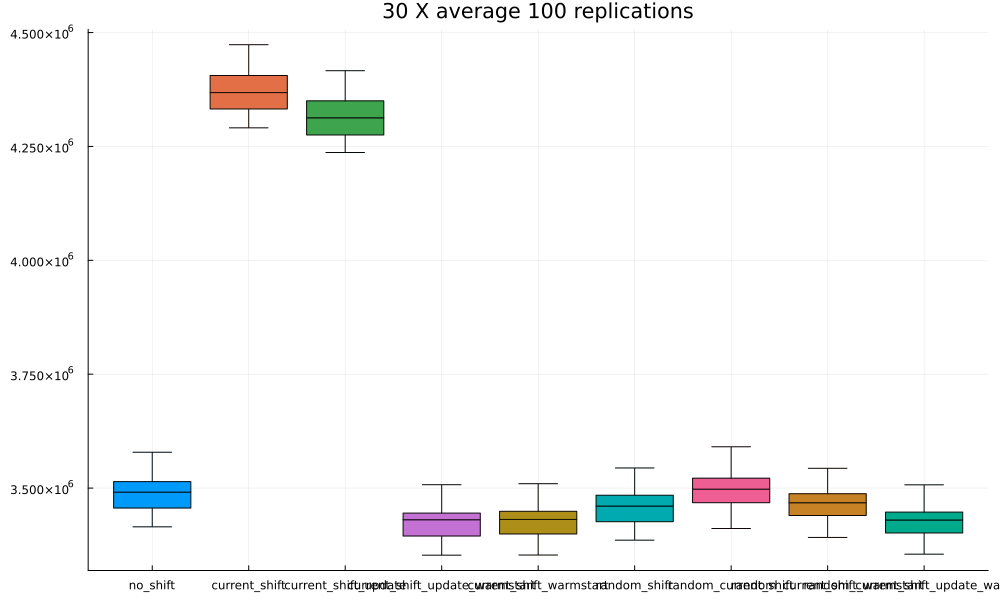

In [22]:
# H=[mean.(Serialization.deserialize("results/141_without/oos/oos$i.jls")) for i in 1:30]

mean_shift=[[Cost[i][labels[k]] for i in 1:30] for k in 1:N]

valeurs = vcat(mean_shift)

p=boxplot(valeurs, xticks = (1:N, labels), title="30 X average 100 replications", legend=false, size=(1000, 600))

In [ ]:
model_dict = Dict(shift => Serialization.deserialize("results/N100/$(shift)/model.jls") for shift in shift_list)
# cuts_dict  = Dict(shift => Serialization.deserialize("results/141_without/$(shift)/Cuts.jls")  for shift in shift_list)
# time_dict  = Dict(shift => Serialization.deserialize("results/141_without/$(shift)/time.jls")  for shift in shift_list)

for shift in shift_list
    for i in 1:12
        set_optimizer(model_dict[shift][i].value_function.model, optimizer)
        set_optimizer(model_dict[shift][i].subproblem, optimizer)
    end
end

MethodError: MethodError: Cannot `convert` an object of type Dict{Symbol, VariableRef} to an object of type SDDP.Cut2
The function `convert` exists, but no method is defined for this combination of argument types.

Closest candidates are:
  SDDP.Cut2(::Any, !Matched::Any, !Matched::Any, !Matched::Any, !Matched::Any, !Matched::Any)
   @ SDDP ~/Documents/SDDP.jl/src/user_interface.jl:643
  convert(::Type{T}, !Matched::T) where T
   @ Base Base.jl:126


In [20]:
for shift in shift_list
    for i in 1:12
        println("Min for "*string(shift)*" :", SDDP.compute_inf_V(model_dict[shift][i].value_function))
    end
end

Min for no_shift :2.803171476966064e6
Min for no_shift :2.8430632772119865e6
Min for no_shift :2.901957019940454e6
Min for no_shift :2.9398503147899825e6
Min for no_shift :2.95477383230703e6
Min for no_shift :2.9499769348199978e6
Min for no_shift :2.927265702621379e6
Min for no_shift :2.889983872158909e6
Min for no_shift :2.839651869950666e6
Min for no_shift :2.7956012424017307e6
Min for no_shift :2.7750295006580036e6
Min for no_shift :2.7622274077707785e6
Min for current_shift :0.0
Min for current_shift :0.0
Min for current_shift :0.0
Min for current_shift :0.0
Min for current_shift :0.0
Min for current_shift :0.0
Min for current_shift :0.0
Min for current_shift :0.0
Min for current_shift :0.0
Min for current_shift :0.0
Min for current_shift :0.0
Min for current_shift :0.0
Min for current_shift_update :0.0
Min for current_shift_update :0.0
Min for current_shift_update :0.0
Min for current_shift_update :0.0
Min for current_shift_update :0.0
Min for current_shift_update :0.0
Min for cur

In [11]:
function compare_threads(model_list, N, i)
    println(i)
    oos = Base.invokelatest(SDDP.compare_models,
        model_list;
        replications = N,
        TimeHorizon = 12*10,
        discount_factor = 0.99,
    )

    println(oos)
end

function compare(shift_list)

    model_list = [Serialization.deserialize("results/141_without/$(shift)/model.jls") for shift in shift_list]
    for model in model_list
        for i in 1:12
            set_optimizer(model[i].value_function.model, optimizer)
            set_optimizer(model[i].subproblem, optimizer)
        end
    end

    for i in 1:1
        compare_threads(model_list,10,i)
    end

end

compare (generic function with 1 method)

In [12]:
compare(shift_list)
# compare_threads(shift_list, 10, 1)

1
Any[[2.6230765122620403e6, 2.450006230266465e6, 2.1800827301597777e6, 3.0190090483876844e6, 2.552690034982523e6, 2.0522649010752295e6, 2.7615141449837727e6, 2.3635823432433773e6, 2.828973337684107e6, 2.5261292414896768e6], [2.5545512487881104e6, 2.432680955664053e6, 2.164854932872658e6, 3.0345969624791075e6, 2.4770809964531423e6, 2.0196490740971297e6, 2.738689926681199e6, 2.375202055649845e6, 2.774227722667018e6, 2.513505130619241e6], [2.5598484041514923e6, 2.4304454080185066e6, 2.1648604610114023e6, 3.016167954923674e6, 2.4796749751498797e6, 2.040450418647611e6, 2.7249286518530343e6, 2.442793310310466e6, 2.683377480751486e6, 2.5058972150496673e6], [2.529811383471636e6, 2.434026866739634e6, 2.1707260131603293e6, 3.018105900973972e6, 2.478476335786809e6, 2.0408292960509863e6, 2.741015814158697e6, 2.379813852683963e6, 2.6694415538773127e6, 2.50303302102209e6], [2.5230961826624693e6, 2.43063951091041e6, 2.1694192802864565e6, 3.026980743550354e6, 2.4764972064433657e6, 2.0251152213622525e

In [13]:
function te()
    model_list = [Serialization.deserialize("results/141_without/$(shift)/model.jls") for shift in shift_list]
    for model in model_list
        for i in 1:12
            set_optimizer(model[i].value_function.model, optimizer)
            set_optimizer(model[i].subproblem, optimizer)
        end
    end
    oos = Base.invokelatest(SDDP.compare_models,
        model_list;
        replications = 1,
        TimeHorizon = 12*10,
        discount_factor = 0.99,
    )
end
te()

5-element Vector{Any}:
 [2.0908542570076063e6]
 [2.0820286460364284e6]
 [2.0963182588555496e6]
 [2.0962740832117973e6]
 [2.0944822802495852e6]

In [14]:
model_list = [Serialization.deserialize("results/141_without/$(shift)/model.jls") for shift in shift_list]
for model in model_list
    for i in 1:12
        set_optimizer(model[i].value_function.model, optimizer)
        set_optimizer(model[i].subproblem, optimizer)
    end
end
SDDP.compare_models(
        model_list;
        replications = 1,
        TimeHorizon = 12*10,
        discount_factor = 0.99,
    )

# SDDP.compare_models(
#         [model_dict[SDDP.no_shift]];
#         replications = 1,
#         TimeHorizon = 12*10,
#         discount_factor = 0.99,
#     )

5-element Vector{Any}:
 [2.594788588853024e6]
 [2.5918108297637817e6]
 [2.601749509013383e6]
 [2.5996926327852686e6]
 [2.596346551845947e6]